In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import random
import PIL
from PIL import Image, ImageOps

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu, enable=True)

os.listdir(f'hw5_data/train/')  # Directory where training data folders are

['Store',
 'LivingRoom',
 'Coast',
 'OpenCountry',
 'Street',
 'Forest',
 'Office',
 'TallBuilding',
 'Highway',
 'Kitchen',
 'InsideCity',
 'Suburb',
 'Mountain',
 'Industrial',
 'Bedroom']

###  Hyperparameters

In [2]:
batch_size = 64  # Training batch size
num_classes = 15  # Classes in dataset
num_epochs = 40   # Epochs for training   
lr = 1e-3  # Learning rate
lr_weight_decay = 1e-3 # Learning weight decay

### Data Processing

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

"""
from albumentations.augmentations.transforms import Rotate
from albumentations import Compose

def augment_and_show(image):
    #image = Equalize(mode='pil', always_apply=True, p=1)(image=np.array(image).astype('uint8'))['image']
    aug = Compose([Rotate(limit=5, interpolation=2, p=1)])
    image = aug(image=image)['image']
    return image.astype('float')
"""

# preprocessing image and divide validaiton set
train_datagen = ImageDataGenerator(horizontal_flip=True, brightness_range=[0.5,1.5], zoom_range=[0.8,1], rotation_range=5)

train_generator = train_datagen.flow_from_directory('hw5_data/train/',
                                                 target_size=(256,256),
                                                 batch_size=batch_size,
                                                 class_mode='sparse',
                                                 shuffle=True,
                                                 subset='training')

validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_directory('hw5_data/test/',target_size=(256,256),
                                                 batch_size=batch_size,
                                                 class_mode='sparse')


# for i in range(25):
#     plt.figure(figsize=(30,20))
#     plt.subplot(5,5,i+1)
#     plt.imshow(train_generator.next()[0][i].astype('uint8'))
#     plt.tight_layout()

Found 1500 images belonging to 15 classes.
Found 150 images belonging to 15 classes.


In [4]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

from classification_models.tfkeras import Classifiers

ResNet50, preprocess_input = Classifiers.get('resnet50')
base_model = ResNet50(input_shape=(256, 256, 3), weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(num_classes, kernel_initializer='zeros')(x)
model = Model(inputs=[base_model.input], outputs=[output])


# Training with the final custom-made layers
# ResNet 50 (48,51)
for layer in model.layers[:48]:
    layer.trainable =False
    
        
for layer in model.layers[48:]:
    layer.trainable=True
    
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

### Callbacks

In [5]:
import math
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras import backend as K


class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=1):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        
cosineanneling = CosineAnnealingScheduler(T_max=5, eta_max=1e-2, eta_min=1e-5)


checkpoint = ModelCheckpoint('logs/ep{epoch:03}-val_loss{val_loss:.3f}.h5', save_best_only=False, save_weight_only=True, monitor='val_loss', mode='min', verbose=1)

In [6]:
from tensorflow.keras import optimizers
# Use default adam optimizer (learning rate=1e-3, decay=0)
# Loss function: categorical cross entropy
# Evaluation: Accuracy

sgd = optimizers.SGD(lr=1e-3, momentum=0.9, decay=1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=sgd, loss=loss_fn, metrics=['accuracy'])


step_size_train = train_generator.n // train_generator.batch_size
step_size_val = validation_generator.n // validation_generator.batch_size

history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train,
                              validation_data=validation_generator, validation_steps=step_size_val,
                              epochs=num_epochs , callbacks=[cosineanneling, checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: CosineAnnealingScheduler setting learning rate to 0.01.
Epoch 1/40
23/23 [==============================] - ETA: 0s - loss: 1.5919 - accuracy: 0.5482
Epoch 00001: saving model to logs/ep001-val_loss0.831.h5
23/23 [==============================] - 17s 746ms/step - loss: 1.5919 - accuracy: 0.5482 - val_loss: 0.8311 - val_accuracy: 0.7031 - lr: 0.0100

Epoch 00002: CosineAnnealingScheduler setting learning rate to 0.009046039886902862.
Epoch 2/40
23/23 [==============================] - ETA: 0s - loss: 0.3007 - accuracy: 0.8962
Epoch 00002: saving model to logs/ep002-val_loss0.540.h5
23/23 [==============================] - 17s 723ms/step - loss: 0.3007 - accuracy: 0.8962 - val_loss: 0.5395 - val_accuracy: 0.7969 - lr: 0.0090

Epoch 00003: CosineAnnealingScheduler setting learning rate to 0.006548539886902863.
Epoch 3/40
23/23 [==============================] - ETA: 0s - loss: 0.1426 - accuracy: 0.9


Epoch 00022: CosineAnnealingScheduler setting learning rate to 0.009046039886902864.
Epoch 22/40
23/23 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 1.0000
Epoch 00022: saving model to logs/ep022-val_loss0.188.h5
23/23 [==============================] - 17s 747ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.1878 - val_accuracy: 0.9375 - lr: 0.0090

Epoch 00023: CosineAnnealingScheduler setting learning rate to 0.006548539886902874.
Epoch 23/40
23/23 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9986
Epoch 00023: saving model to logs/ep023-val_loss0.188.h5
23/23 [==============================] - 17s 722ms/step - loss: 0.0067 - accuracy: 0.9986 - val_loss: 0.1879 - val_accuracy: 0.9453 - lr: 0.0065

Epoch 00024: CosineAnnealingScheduler setting learning rate to 0.0034614601130971406.
Epoch 24/40
23/23 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 1.0000
Epoch 00024: saving model to logs/ep024-val_loss0.11

### Multi-GPU

In [7]:
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
# from tensorflow.keras.models import Model
# import efficientnet.tfkeras as efn 
# import tensorflow as tf
# from tensorflow.keras import optimizers

# def get_compiled_model():

#     base_model = efn.EfficientNetB0(input_shape=(256, 256, 3), weights='imagenet', include_top=False)  # or weights='noisy-student'
#     x = GlobalAveragePooling2D()(base_model.output)
#     output = Dense(num_classes, activation='softmax')(x)
#     model = Model(inputs=[base_model.input], outputs=[output])
    
# #     for layer in model.layers[:22]:
# #         layer.trainable =False

# #     for layer in model.layers[22:]:
# #         layer.trainable=True

#     sgd = optimizers.SGD(lr=1e-3, momentum=0.9, decay=1e-3)
#     model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
#     return model

# strategy = tf.distribute.MirroredStrategy()
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))



# step_size_train = train_generator.n // train_generator.batch_size
# step_size_val = validation_generator.n // validation_generator.batch_size


# with strategy.scope():
#   # Everything that creates variables should be under the strategy scope.
#   # In general this is only model construction & `compile()`.
#     model = get_compiled_model()
   
    
# history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train,
#                               validation_data=validation_generator, validation_steps=step_size_val,
#                               epochs=num_epochs , callbacks=[cosineanneling, checkpoint])

### Visualization

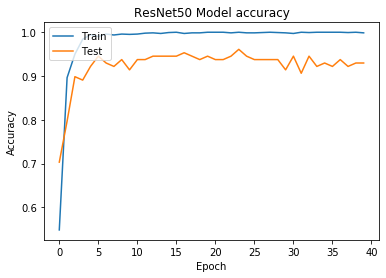

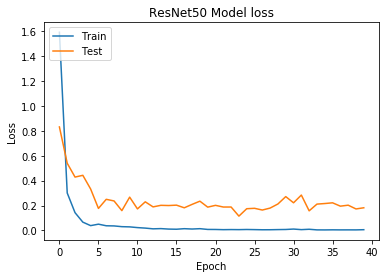

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Testing

In [9]:
class_label =  os.listdir(f'hw5_data/train/')

def DataLoader(path, standardize=False):
    img_list = []
    label_list = []
    num_img = 0
    for classes in class_label:
        for img in os.listdir(f'hw5_data/{path}/{classes}'):
            if img.endswith('.jpg'):
                label_list.append(classes)
                original = cv2.imread(f'hw5_data/{path}/{classes}/{img}')
                

                #original = augment_and_show(original)
                resized_img = cv2.resize(original, (256, 256), interpolation=cv2.INTER_CUBIC)

                img_list.append(resized_img)
                num_img += 1
    #img_list = img_list.T[1:,:]
    return np.array(img_list), label_list, num_img


test_img, test_label, num_test = DataLoader('test', standardize=False)

dic = train_generator.class_indices
label_num = []

for label in test_label:
    label_num.append(dic[label])

In [10]:
for log in sorted(os.listdir(f'./logs/')):
    model.load_weights(f'logs/{log}')
    print(log)
    print(np.count_nonzero(np.argmax(model.predict(test_img), axis=1) == label_num) / num_test)

ep27-val_loss0.154.h5
0.98
ep29-val_loss0.122.h5
0.98
ep30-val_loss0.141.h5
0.98


# Grad-CAM class activation visualization
[Keras - How to obtain a class activation heatmap for an image classification model](https://keras.io/examples/vision/grad_cam/)

In [11]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

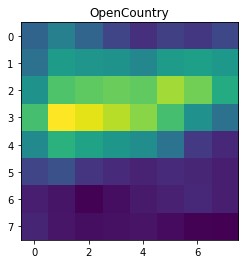

In [12]:
# Prepare image
idx = np.random.choice(len(test_img))
img = test_img[idx]

last_conv_layer_name = 'stage4_unit3_conv3'

classifier_layer_names = [
    "global_average_pooling2d",
    "dense",
]

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    np.expand_dims(img, axis=0), model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.title(test_label[idx])
plt.imshow(heatmap);

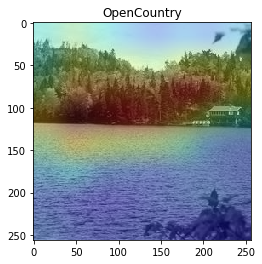

In [13]:
# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)


# Display Grad CAM
plt.title(test_label[idx])
plt.imshow(superimposed_img);